In [1]:
import os
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time
import math
from tensorflow import keras
import seaborn as sns
import random
import tensorflow as tf
from sklearn.metrics import confusion_matrix

In [2]:
def find_max_wave_height(zdisp_window):
    zero_crossings = np.where(np.diff(np.sign(zdisp_window)))[0]
    zero_crossings= np.append(zero_crossings, len(zdisp_window)-1);
    zero_crossings= np.append(-1,zero_crossings)
    h_wave=np.zeros(len(zero_crossings)-1)
    t_wave=np.zeros(len(zero_crossings)-1)
            
    for iter_zero_crossing in range(len(zero_crossings)-1):
        peak_idx=np.argmax(np.abs(zdisp_window[zero_crossings[iter_zero_crossing]+1:zero_crossings[iter_zero_crossing+1]+1]))
        h_wave[iter_zero_crossing]=zdisp_window[zero_crossings[iter_zero_crossing]+1+peak_idx]
        t_wave[iter_zero_crossing]=zero_crossings[iter_zero_crossing]+1+peak_idx
                
    max_wave_height=max(np.abs(np.diff(h_wave)))
    max_index = int(t_wave[np.argmax(np.abs(np.diff(h_wave)))])
    
    return max_wave_height, max_index

In [3]:
def populate_rw_arrays(dir, array, start_idx, end_idx):
    for folder in os.listdir(dir):
        print("Processing: " + folder)
        
        start_time = time.time()
        for file in os.listdir(dir+ "/" + folder):
            if file.endswith(".npz"):
                data=np.load(dir+"/"+ folder+"/"+file)
                z_tmp=data['zdisp'][start_idx:end_idx]
                #print(z_tmp.shape)
                significant_wave_height=4*np.std(data['zdisp'])#[start_idx:-1]
                #if folder=='Buoy_067':
                #    z_disp_rw_buoy_067.append(z_tmp/significant_wave_height)
                #else:
               # z_disp_rw.append(z_tmp/significant_wave_height) 
                z_disp_rw.append(z_tmp/significant_wave_height)
                #print(z_disp_rw[0].shape)
        print("--- %s seconds ---" % (time.time() - start_time))
    return

In [4]:
def populate_norw_arrays(dir, array, end_idx):
    for folder in os.listdir(dir):
        print("Processing: " + folder)
        
        start_time = time.time()
        for file in os.listdir(dir+ "/" + folder):
            if file.endswith(".npz"):
                data=np.load(dir+"/"+ folder+"/"+file)
                z_tmp=data['zdisp_norw'][0:end_idx]
                #print(z_tmp.shape)
                significant_wave_height=4*np.std(data['zdisp_norw'])#[start_idx:-1]
                #if folder=='Buoy_067':
                #    z_disp_rw_buoy_067.append(z_tmp/significant_wave_height)
                #else:
               # z_disp_rw.append(z_tmp/significant_wave_height) 
                z_disp_norw.append(z_tmp/significant_wave_height)

        print("--- %s seconds ---" % (time.time() - start_time))
    return          

In [5]:
#num_samples_each_type = int(input("Enter the number of each type of wave sample: ")) 
#num_samples_each_type = 50000 

# root_folder_rw = os.getcwd()+"/buoy_network_g2_deep"
# root_folder_norw = os.getcwd()+"/buoy_network_g2_deep"
root_folder_rw = os.getcwd()+"/buoy_network_g2_deep_testing"
root_folder_norw = os.getcwd()+"/buoy_network_g2_deep_testing"

#root_folder="E:/"

window_start_min_rel_to_rw=-18
window_length_in_min=15

samplerate=1.28

rw_idx=round(25*60*samplerate)
start_idx=round((25+window_start_min_rel_to_rw)*60*samplerate)
end_idx=start_idx+round(window_length_in_min*60*samplerate)

rw_dir=root_folder_rw + '/rw_samples'
z_disp_rw=[] 
#z_disp_rw_buoy_067=[] 
populate_rw_arrays(rw_dir, z_disp_rw, start_idx, end_idx)

z_disp_norw=[]
#z_disp_norw_buoy_067=[]
norw_dir=root_folder_norw + '/norw_samples'
#norw_dir=root_folder_norw 
end_idx=end_idx-start_idx
populate_norw_arrays(norw_dir, z_disp_norw, end_idx)

Processing: Buoy_222
--- 2.361856460571289 seconds ---
Processing: Buoy_222
--- 2.3873910903930664 seconds ---


In [6]:
z_disp_rw=np.vstack(z_disp_rw)
#z_disp_rw_buoy_067=np.vstack(z_disp_rw_buoy_067)
print(z_disp_rw.shape)

z_disp_norw=np.vstack(z_disp_norw)
#z_disp_norw_buoy_067=np.vstack(z_disp_norw_buoy_067)

print(z_disp_norw.shape)

(1269, 1152)
(1269, 1152)


np.random.seed(5)
num_labels = 25000
len_array_rw = len(z_disp_rw)
len_array_norw = len(z_disp_norw)

indices_rw = np.random.choice(len_array_rw, num_labels, replace=False)
indices_norw = np.random.choice(len_array_norw, num_labels, replace=False)

z_disp_rw_modified = z_disp_rw[indices_rw]
z_disp_norw_modified = z_disp_norw[indices_norw]

print(z_disp_rw_modified.shape)
print(z_disp_norw_modified.shape)

In [7]:
possible_total_waves = round(z_disp_rw.shape[0] + z_disp_norw.shape[0])
print(f"Total possible waves in our study: {possible_total_waves}")

Total possible waves in our study: 2538


The number of rogue wave samples in the case with relative rogue wave ratio 0.5 is 1269.
The number of non-rogue wave samples in the case with relative rogue wave ratio 0.5 is 1269.
The total number of wave samples in the case with relative rogue wave ratio 0.5 is 2538.
(1269, 1152)
(1269, 1152)


1225
691
122


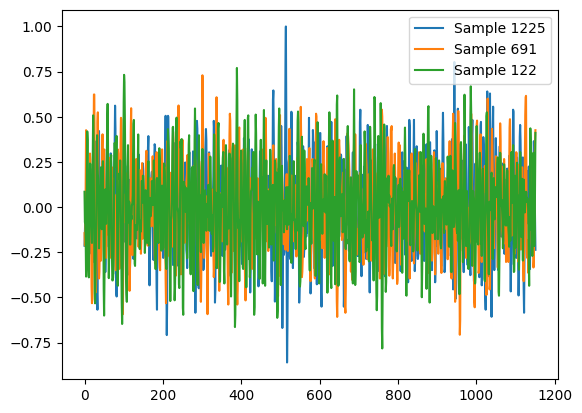

In [8]:
N_data=min([z_disp_rw.shape[0],z_disp_norw.shape[0]])#-1#-110001  #-1
# relative_rw = [0.2, 0.3, 0.4, 0.5, 0.6 ,0.7, 0.8]
relative_rw = [0.5]

for i in range(len(relative_rw)):
    ratio = relative_rw[i]
    if ratio >= 0.5:
        num_rw = z_disp_rw.shape[0]
        num_norw = round(((1-ratio)/ratio) * num_rw)
    else:
        num_norw = z_disp_norw.shape[0]
        num_rw = round((ratio / (1-ratio))*num_norw)

    print(f"The number of rogue wave samples in the case with relative rogue wave ratio {ratio} is {num_rw}.")
    print(f"The number of non-rogue wave samples in the case with relative rogue wave ratio {ratio} is {num_norw}.")
    print(f"The total number of wave samples in the case with relative rogue wave ratio {ratio} is {num_rw + num_norw}.", end='\n') 
        
    z_disp_rw_altered = z_disp_rw[0:num_rw]
    z_disp_norw_altered = z_disp_norw[0:num_norw]
    
    print(z_disp_rw_altered.shape)
    print(z_disp_norw_altered.shape)
    print('\n')

    N_plots=3
    selected_samples=random.sample(range(0, len(z_disp_rw)), N_plots)

    plt.figure()
    for iter_plot in selected_samples:
        print(iter_plot)
        plt.plot(z_disp_rw[iter_plot,:], label='Sample '+str(iter_plot))

    plt.legend(loc='best')    
    plt.show()
    plt.close()

    wave_data=np.concatenate((z_disp_rw_altered, z_disp_norw_altered), axis=0)
    labels=np.concatenate(( np.ones(len(z_disp_rw_altered)) , np.zeros(len(z_disp_norw_altered))),axis=0)

    #wave_data_buoy_067=np.concatenate((z_disp_rw_buoy_067, z_disp_norw_buoy_067), axis=0)
    #labels_067=np.concatenate(( np.ones(len(z_disp_rw_buoy_067)) , np.zeros(len(z_disp_norw_buoy_067))),axis=0)

    idx = np.random.permutation(len(wave_data))
    wave_data = wave_data[idx]
    labels=labels[idx]


    # wave_data_train=wave_data[0:round(0.8*len(wave_data))]
    # wave_data_test=wave_data[round(0.8*len(wave_data))+1:]                                      

    # label_train=labels[0:round(0.8*len(wave_data))]
    # label_test=labels[round(0.8*len(wave_data))+1:]

    wave_data_train=wave_data[0:round(0*len(wave_data))]
    wave_data_test=wave_data[round(0*len(wave_data))+1:]                                      

    label_train=labels[0:round(0*len(wave_data))]
    label_test=labels[round(0*len(wave_data))+1:]


    wave_data_train = wave_data_train.reshape((wave_data_train.shape[0], wave_data_train.shape[1], 1))
    wave_data_test = wave_data_test.reshape((wave_data_test.shape[0], wave_data_test.shape[1], 1))

    num_classes=2

    np.savez(os.getcwd()  +f'/DataPrepared/RWs_H_g_2_tadv_3min_deep_buoys_test_rw_{ratio}',wave_data_train=wave_data_train, wave_data_test=wave_data_test,label_train=label_train,label_test=label_test)